In [2]:
# -*- coding:utf-8 -*-
# @Python Version: 3.7
# @Time: 2020/5/18 23:31
# @Author: Michael Ming
# @Website: https://michael.blog.csdn.net/
# @File: ks_baselineModel.ipynb
# @Reference: https://www.kaggle.com/learn/feature-engineering
import pandas as pd

ks = pd.read_csv('ks-projects-201801.csv',parse_dates=['deadline','launched'])
ks.head(10)
pd.unique(ks.state)
ks.groupby('state')['ID'].count()
ks = ks.query('state != "live"')
ks = ks.assign(outcome=(ks['state']=='successful').astype(int))
ks = ks.assign(hour=ks.launched.dt.hour,
               day=ks.launched.dt.day,
               month=ks.launched.dt.month,
               year=ks.launched.dt.year)
# ks.head()

In [3]:
from sklearn.preprocessing import LabelEncoder

cat_features = ['category','currency','country']
encoder = LabelEncoder()

encoded = ks[cat_features].apply(encoder.fit_transform)

In [4]:
encoded.head(10)

X = ks[['goal', 'hour', 'day', 'month', 'year', 'outcome']].join(encoded)
X.head()

,goal,hour,day,month,year,outcome,category,currency,country
0,1000.0,12,11,8,2015,0,108,5,9
1,30000.0,4,2,9,2017,0,93,13,22
2,45000.0,0,12,1,2013,0,93,13,22
3,5000.0,3,17,3,2012,0,90,13,22
4,19500.0,8,4,7,2015,0,55,13,22


In [5]:
valid_ratio = 0.1
valid_size = int(len(X)*valid_ratio)
train = X[ : -2*valid_size]
valid = X[-2*valid_size : -valid_size]
test = X[-valid_size : ]
train.outcome.mean()

0.35697894841863714

In [6]:
for each in [train, valid, test]:
    print("Outcome fraction = {:.4f}".format(each.outcome.mean()))

Outcome fraction = 0.3570
Outcome fraction = 0.3539
Outcome fraction = 0.3542


In [22]:
interactions = ks['category']+'_'+ks['country']
interactions.head(10)

label_enc = LabelEncoder()
data_interaction = X.assign(category_country=
                            label_enc.fit_transform(interactions))
data_interaction.head()

launched = pd.Series(ks.index, index=ks.launched, name="count_7_days").sort_index()
launched.head(20)

count_7_days = launched.rolling('7d').count()-1
print(count_7_days.head(20))

launched
1970-01-01 01:00:00     0.0
1970-01-01 01:00:00     1.0
1970-01-01 01:00:00     2.0
1970-01-01 01:00:00     3.0
1970-01-01 01:00:00     4.0
1970-01-01 01:00:00     5.0
1970-01-01 01:00:00     6.0
2009-04-21 21:02:48     0.0
2009-04-23 00:07:53     1.0
2009-04-24 21:52:03     2.0
2009-04-25 17:36:21     3.0
2009-04-27 14:10:39     4.0
2009-04-28 13:55:41     5.0
2009-04-29 02:04:21     5.0
2009-04-29 02:58:50     6.0
2009-04-29 04:37:37     7.0
2009-04-29 05:26:32     8.0
2009-04-29 06:43:44     9.0
2009-04-29 13:52:03    10.0
2009-04-29 22:08:13    11.0
Name: count_7_days, dtype: float64


In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.plot(count_7_days[7:])
plt.title("最近7天的数据")
plt.show()

OverflowError: Exceeded cell block limit (set 'agg.path.chunksize' rcparam)

<Figure size 432x288 with 1 Axes>

Int64Index([ 94579, 319002, 247913,  48147,  75397,   2842, 273779, 169268,
            322000, 138572,
            ...
            177716, 111813, 322184,  46681, 200261, 339929,  62039,  11463,
            167940,  15604],
           dtype='int64', length=375862)


In [36]:
count_7_days.index = launched.values
count_7_days = count_7_days.reindex(ks.index)
count_7_days.head(10)
X.join(count_7_days).head(10)

,goal,hour,day,month,year,outcome,category,currency,country,count_7_days
0,1000.0,12,11,8,2015,0,108,5,9,1355.0
1,30000.0,4,2,9,2017,0,93,13,22,1789.0
2,45000.0,0,12,1,2013,0,93,13,22,749.0
3,5000.0,3,17,3,2012,0,90,13,22,968.0
4,19500.0,8,4,7,2015,0,55,13,22,757.0
5,50000.0,13,26,2,2016,1,123,13,22,2070.0
6,1000.0,18,1,12,2014,1,58,13,22,1021.0
7,25000.0,20,1,2,2016,0,41,13,22,438.0
8,125000.0,18,24,4,2014,0,113,13,22,862.0
9,65000.0,21,11,7,2014,0,39,13,22,1435.0


In [43]:
def time_since_last_project(series):
    return series.diff().dt.total_seconds()/3600
df = ks[['category','launched']].sort_values('launched')
df
timedeltas = df.groupby('category').transform(time_since_last_project)
timedeltas.head(20)

timedeltas = timedeltas.fillna(timedeltas.median()).reindex(X.index)
timedeltas.head(20)

,launched
0,18.606111
1,5.592778
2,1.313611
3,0.635000
4,16.661389
5,2.629722
6,0.367500
7,12.286111
8,14.243611
9,0.174722


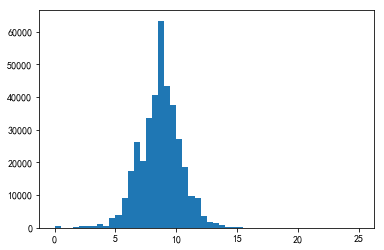

In [49]:
import  numpy as np
# plt.hist(ks.goal, range=(0,100000),bins=50);

plt.hist(np.log(ks.goal), range=(0, 25), bins=50);